# FVM Backward Facing Step

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/examples/mesh/FVM_BackStep.ipynb)

This example shows how to run a finite volumes incompressible fluid simulation on an unstructured mesh.

In [10]:
%pip install --quiet phiflow
from phi.jax.flow import *
# from phi.flow import *  # If JAX is not installed. You can use phi.torch or phi.tf as well.
from tqdm.notebook import trange

<Figure size 864x360 with 1 Axes>

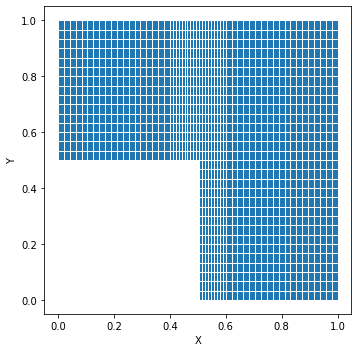

In [11]:
obstacle = Box(x=.5, y=.5)
vert_x = concat([
    math.linspace(0, .4, spatial(x=20))[:-1],
    math.linspace(.4, .6, spatial(x=20))[:-1],
    math.linspace(.6, 1, spatial(x=20)),
    ], 'x')
vert_y = math.linspace(0, 1, spatial(y=31))
mesh = geom.build_mesh(x=vert_x, y=vert_y, obstacles=obstacle)
plot(mesh)

In [12]:
@jit_compile_linear
def momentum_eq(u, u_prev, dt, diffusivity=0.01):
    diffusion_term = dt * diffuse.differential(u, diffusivity, correct_skew=False)
    advection_term = dt * advect.differential(u, u_prev, order=1)
    return u + advection_term + diffusion_term

@jit_compile
def implicit_time_step(v, dt):
    v = math.solve_linear(momentum_eq, v, Solve(x0=v), u_prev=v, dt=-dt)
    v, p = fluid.make_incompressible(v)
    return v

In [13]:
boundary = {'x-': vec(x=.1, y=0), 'obstacle': 0, 'y': 0, 'x+': ZERO_GRADIENT}
velocity = Field(mesh, tensor(vec(x=0, y=0)), boundary)
v_trj = math.iterate(implicit_time_step, batch(time=100), velocity, dt=0.01, range=trange)

  0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
plot(v_trj, v_trj.to_grid(), animate='time')